In [3]:
 
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
for backend in service.backends():
    config = backend.configuration()
    if "simulator" in config.backend_name:
        continue
    print(f"Backend: {config.backend_name}")
    print(f"    Processor type: {config.processor_type}")
    print(f"    Supported instructions:")
    for instruction in config.supported_instructions:
        print(f"        {instruction}")
    print()

Backend: ibm_fez
    Processor type: {'family': 'Heron', 'revision': '2'}
    Supported instructions:
        cz
        id
        delay
        measure
        reset
        rz
        sx
        x
        if_else

Backend: ibm_marrakesh
    Processor type: {'family': 'Heron', 'revision': '2'}
    Supported instructions:
        cz
        id
        delay
        measure
        reset
        rz
        sx
        x
        if_else

Backend: ibm_torino
    Processor type: {'family': 'Heron', 'revision': '1'}
    Supported instructions:
        cz
        id
        delay
        measure
        reset
        rz
        sx
        x
        if_else



In [5]:
from qiskit.circuit import (
    Parameter,
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
)
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives.containers import BitArray
 
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
 
import numpy as np
 
# Instantiate runtime service and get
# the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
 
# Define a circuit with two parameters.
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(Parameter("a"), 0)
circuit.rz(Parameter("b"), 0)
circuit.cx(0, 1)
circuit.h(0)
 
# Transpile the circuit
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)
layout = transpiled_circuit.layout
 
# Now define a sweep over parameter values, the last axis of dimension 2 is
# for the two parameters "a" and "b"
params = np.vstack(
    [
        np.linspace(-np.pi, np.pi, 100),
        np.linspace(-4 * np.pi, 4 * np.pi, 100),
    ]
).T
 
# Define three observables. The inner length-1 lists cause this array of
# observables to have shape (3, 1), rather than shape (3,) if they were
# omitted.
observables = [
    [SparsePauliOp(["XX", "IY"], [0.5, 0.5])],
    [SparsePauliOp("XX")],
    [SparsePauliOp("IY")],
]
# Apply the same layout as the transpiled circuit.
observables = [
    [observable.apply_layout(layout) for observable in observable_set]
    for observable_set in observables
]
 
# Estimate the expectation value for all 300 combinations of observables
# and parameter values, where the pub result will have shape (3, 100).
#
# This shape is due to our array of parameter bindings having shape
# (100, 2), combined with our array of observables having shape (3, 1).
estimator_pub = (transpiled_circuit, observables, params)
 
# Instantiate the new estimator object, then run the transpiled circuit
# using the set of parameters and observables.
estimator = Estimator(mode=backend)
job = estimator.run([estimator_pub])
result = job.result()

## Broadcasting rules  
The PUBs aggregate elements from multiple arrays (observables and parameter values) by following the same broadcasting rules as NumPy

In [ ]:
# Broadcast single observable
 
 
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = SparsePauliOp("ZZZ")  # shape ()
# >> pub result has shape (5,)
 
# Zip
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = [
    SparsePauliOp(pauli) for pauli in ["III", "XXX", "YYY", "ZZZ", "XYZ"]
]  # shape (5,)
# >> pub result has shape (5,)
 
# Outer/Product
parameter_values = np.random.uniform(size=(1, 6))  # shape (1, 6)
observables = [
    [SparsePauliOp(pauli)] for pauli in ["III", "XXX", "YYY", "ZZZ"]
]  # shape (4, 1)
# >> pub result has shape (4, 6)
 
# Standard nd generalization
parameter_values = np.random.uniform(size=(3, 6))  # shape (3, 6)
observables = [
    [
        [SparsePauliOp(["XII"])],
        [SparsePauliOp(["IXI"])],
        [SparsePauliOp(["IIX"])],
    ],
    [
        [SparsePauliOp(["ZII"])],
        [SparsePauliOp(["IZI"])],
        [SparsePauliOp(["IIZ"])],
    ],
]
# >> pub result has shape (2, 3, 6)

## Estimator output

In [19]:
print(
    f"The result of the submitted job had {len(result)} PUB and has a value:\n {result}\n"
)
print(
    f"The associated PubResult of this job has the following data bins:\n {result[0].data}\n"
)
print(f"And this DataBin has attributes: {result[0].data.keys()}")
print(
    "Recall that this shape is due to our array of parameter binding sets having shape (100, 2) -- where 2 is the\n\
         number of parameters in the circuit -- combined with our array of observables having shape (3, 1). \n"
)
print(
    f"The expectation values measured from this PUB are: \n{result[0].data.evs}"
)

The result of the submitted job had 1 PUB and has a value:
 PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(3, 100), dtype=float64>), stds=np.ndarray(<shape=(3, 100), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(3, 100), dtype=float64>), shape=(3, 100)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

The associated PubResult of this job has the following data bins:
 DataBin(evs=np.ndarray(<shape=(3, 100), dtype=float64>), stds=np.ndarray(<shape=

## Sampler output

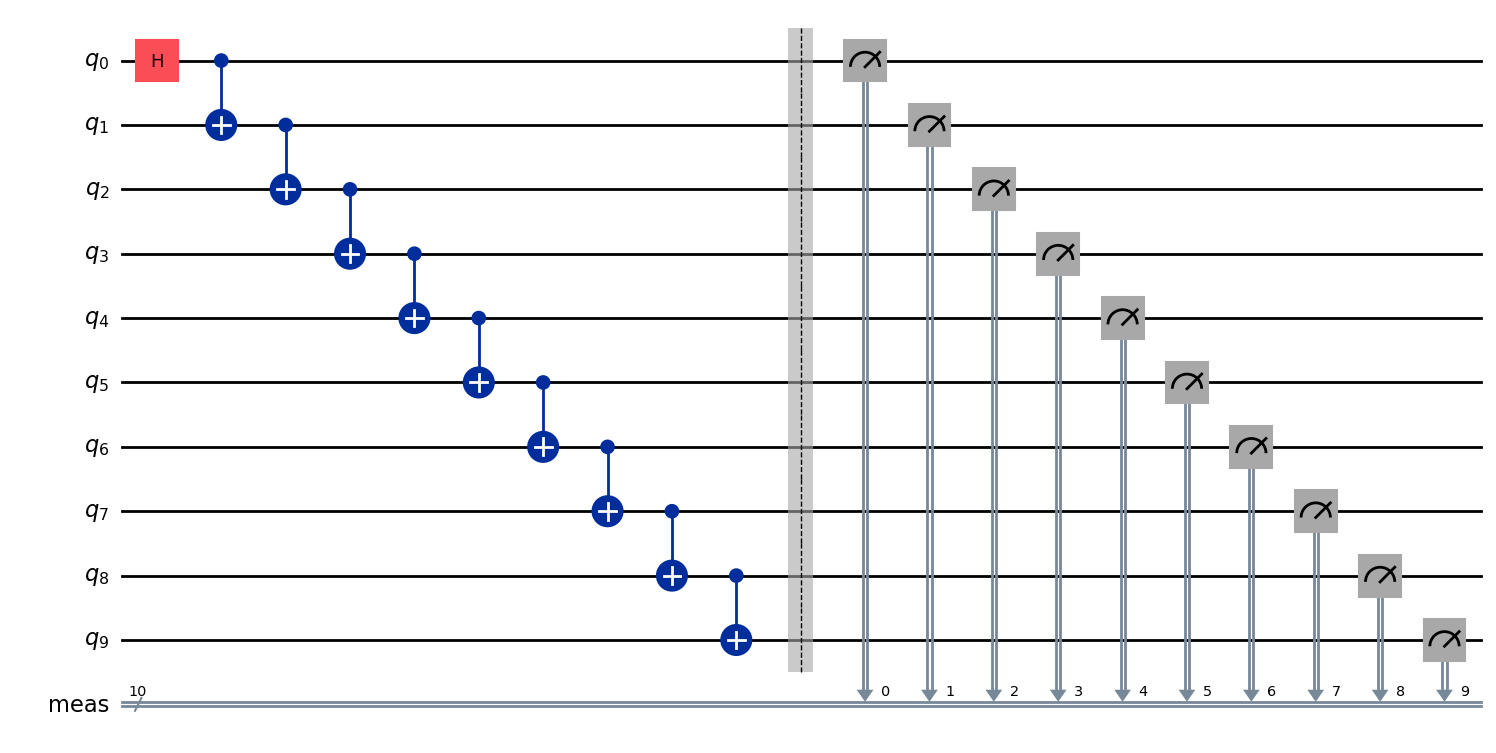

In [25]:
circuit.draw('mpl')

In [ ]:
# generate a ten-qubit GHZ circuit
circuit = QuantumCircuit(10)
circuit.h(0)
circuit.cx(range(0, 9), range(1, 10))
 
# append measurements with the `measure_all` method
circuit.measure_all()
 
# transpile the circuit
transpiled_circuit = pm.run(circuit)
 
# run the Sampler job and retrieve the results
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_circuit])
result = job.result()
 
# the data bin contains one BitArray
data = result[0].data
print(f"Databin: {data}\n")
 
# to access the BitArray, use the key "meas", which is the default name of
# the classical register when this is added by the `measure_all` method
array = data.meas
print(f"BitArray: {array}\n")
print(f"The shape of register `meas` is {data.meas.array.shape}.\n")
print(f"The bytes in register `alpha`, shot by shot:\n{data.meas.array}\n")

Databin: DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=10>))

BitArray: BitArray(<shape=(), num_shots=4096, num_bits=10>)

The shape of register `meas` is (4096, 2).

The bytes in register `alpha`, shot by shot:
[[  2   0]
 [  0   0]
 [  0   0]
 ...
 [  2   0]
 [  0   0]
 [  3 255]]



In [36]:
data.beta.array.shape

(4096, 2)

In [26]:
# generate a ten-qubit GHZ circuit with two classical registers
circuit = QuantumCircuit(
    qreg := QuantumRegister(10),
    alpha := ClassicalRegister(1, "alpha"),
    beta := ClassicalRegister(9, "beta"),
)
circuit.h(0)
circuit.cx(range(0, 9), range(1, 10))
 
# append measurements with the `measure_all` method
circuit.measure([0], alpha)
circuit.measure(range(1, 10), beta)
 
# transpile the circuit
transpiled_circuit = pm.run(circuit)
 
# run the Sampler job and retrieve the results
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_circuit])
result = job.result()
 
# the data bin contains two BitArrays, one per register, and can be accessed
# as attributes using the registers' names
data = result[0].data
print(f"BitArray for register 'alpha': {data.alpha}")
print(f"BitArray for register 'beta': {data.beta}")

BitArray for register 'alpha': BitArray(<shape=(), num_shots=4096, num_bits=1>)
BitArray for register 'beta': BitArray(<shape=(), num_shots=4096, num_bits=9>)


In [37]:
data.beta.array

array([[  1, 255],
       [  1, 255],
       [  1, 239],
       ...,
       [  0,   0],
       [  0,   0],
       [  0,   0]], dtype=uint8)

In [ ]:
print(f"The shape of register `alpha` is {data.alpha.array.shape}.")
print(f"The bytes in register `alpha`, shot by shot:\n{data.alpha.array}\n")
 
print(f"The shape of register `beta` is {data.beta.array.shape}.")
print(f"The bytes in register `beta`, shot by shot:\n{data.beta.array}\n")
 
# post-select the bitstrings of `beta` based on having sampled "1" in `alpha`
mask = data.alpha.array == "0b1"
ps_beta = data.beta[mask[:, 0]]
print(f"The shape of `beta` after post-selection is {ps_beta.array.shape}.")
print(f"The bytes in `beta` after post-selection:\n{ps_beta.array}")
 
# get a slice of `beta` to retrieve the first three bits
beta_sl_bits = data.beta.slice_bits([0, 1, 2])
print(
    f"The shape of `beta` after bit-wise slicing is {beta_sl_bits.array.shape}."
)
print(f"The bytes in `beta` after bit-wise slicing:\n{beta_sl_bits.array}\n")
 
# get a slice of `beta` to retrieve the bytes of the first five shots
beta_sl_shots = data.beta.slice_shots([0, 1, 2, 3, 4])
print(
    f"The shape of `beta` after shot-wise slicing is {beta_sl_shots.array.shape}."
)
print(
    f"The bytes in `beta` after shot-wise slicing:\n{beta_sl_shots.array}\n"
)
 
# calculate the expectation value of diagonal operators on `beta`
ops = [SparsePauliOp("ZZZZZZZZZ"), SparsePauliOp("IIIIIIIIZ")]
exp_vals = data.beta.expectation_values(ops)
for o, e in zip(ops, exp_vals):
    print(f"Exp. val. for observable `{o}` is: {e}")
 
# concatenate the bitstrings in `alpha` and `beta` to "merge" the results of the two
# registers
merged_results = BitArray.concatenate_bits([data.alpha, data.beta])
print(f"\nThe shape of the merged results is {merged_results.array.shape}.")
print(f"The bytes of the merged results:\n{merged_results.array}\n")

The shape of register `alpha` is (4096, 1).
The bytes in register `alpha`, shot by shot:
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]

The shape of register `beta` is (4096, 2).
The bytes in register `beta`, shot by shot:
[[  1 255]
 [  1 255]
 [  1 239]
 ...
 [  0   0]
 [  0   0]
 [  0   0]]

The shape of `beta` after post-selection is (0, 2).
The bytes in `beta` after post-selection:
[]
The shape of `beta` after bit-wise slicing is (4096, 1).
The bytes in `beta` after bit-wise slicing:
[[7]
 [7]
 [7]
 ...
 [0]
 [0]
 [0]]

The shape of `beta` after shot-wise slicing is (5, 2).
The bytes in `beta` after shot-wise slicing:
[[  1 255]
 [  1 255]
 [  1 239]
 [  1 255]
 [  0 255]]

Exp. val. for observable `SparsePauliOp(['ZZZZZZZZZ'],
              coeffs=[1.+0.j])` is: 0.08935546875
Exp. val. for observable `SparsePauliOp(['IIIIIIIIZ'],
              coeffs=[1.+0.j])` is: 0.04638671875

The shape of the merged results is (4096, 2).
The bytes of the merged results:
[[  3 255]
 [  3 255]
 [  3 223]